## Dataset

Dataset is from Meetup RSVP streaming API. Each observation is a users response rsvp=yes/no to a certain event hosted by a certain group, which is associated with various tags (called urlkey)

See diagram below:

![](img/datamodel-crop.png)

### Sample Data

We have real-time streamed rsvp data with the following information:

| event_name    | group_name    | urlkey| response |
| ------------- |:-------------:|:-----:|---------:|
| Nine Famous Graphs and How to Make them Interactive     | SF Data Science | [data-science, big-data, data-visualization, data-mining, machine-learning, big-data-analytics, softwaredev, data-analytics, data-scientist, python, open-data, mapreduce, real-time-analytics, data-journalism, data] | yes |
|Steilacoom Guided Walk 5 or 10km - Traditional Volksmarch            |South Sound Walkers Meetup Group|[walkers, volkssport, fitness, outdoors] | yes |
|Business Event:  Speed Networking at Magnolia's Pub                  |Jacksonville Young Professionals|[diningout, women, outdoors, travel, newintown, fun-times, young-professionals, professional-networking, business-entrepreneur-networking, small-business-networking, adventure, bucket-list, social, weekend-adventures, professional]        | no |

## Problem Definition

The goal of this experiment is to use ML to categorzie the groups into clusters, then potentially apply supervised learning models to classify future rsvp feeds.

The intuition is, each event/group is related to particular topic category, e.g. outdoor activities, tech (since it's SF), sports, culture, etc. Groups similarity can be defined after studying urlkeys, as urlkeys are more likely to overlap within similar groups.

## Model Selection

There're two selection involved in the process. 

* First, choose a proper distance metric to best model similarity between observations
* Second, choose a clustering model to fit_predict using selected distance metric

### Distance Metrics
Considered existing distance metric:
* cityblock (L1)
* hamming
* jaccard

__jaccard__ Distance Metric will minimize the impact of dimenssionality curse, because it is a "bit-wise similarity distance" metric, range from [0,1], where 0 being identical and 1 being most remote. In particular, it computes:

$$distance = \frac{NNEQ}{NNZ}$$ where $NNEQ$ is number of non-equal dimensions and $NNZ$ is number of nonzero dimensions

The particular challenge of this dataset is, the overall average # of urlkeys per group is relatively high (10+), and total # of unique urlkeys is 5000+ (sparse matrix)

![](img/urlkeys_count.png)

It's fairly vulnerable to curse of dimenssionaltiy. __jaccard__ distance metric will consider "non-intersect" over "union length", which is a good mesurement of similarity and free of the curse.

### Clustering Model

For clustering task, the idea is to use urlkey (as tags) to infer a group association. However, the challenge is, flatening each observation's urlkeys will generate a high dimenssion training dataset (# of dimenssion = # of unique urlkeys), where the real meaning of distance will be weakened and subject to the curse (not as much since we're talking about binary values, but the curse is still there)

The clustering models available for selection is:
* K-means
* DBSCAN
* Hierarchical Clustering

Among the above, __Hierarchical Clustering__ is chosen as clustering model, with __jaccard__ Distance Metric. 

The reason behind choosing hierarchical clustering is because the way hierarchical clustering works. It relies on various distance metrics to decide neighbourhood (pairwise distance), with the objective function to minimize the inter-cluster distance (refer to hierarchical clustering pseudo code for detail). The way it works makes intuitive sense because we don't need random start point as oppose to K-means and more importantly we can control to truncate the height of hierarchical tree at the desired level of generalization judged from plotted dendrogram.

The following shows the difference between `linkage='complete'` and `linkage='average'`. The difference is the way to compute cluster merging criteria:
* `linkage='complete'` will look at max distance between two clusters, to decide merge
* `linkage='average'` will look at average distance between two clusters, to decide merge

The former tends to introduce fewer imbalance sized clusters, while latter tends to have more small clusters. The reason being ..........

![](img/complete_jaccard_1000.png)

![](img/average_jaccard_1000.png)

The result of each is show as below.

...
...
...

In comparison, a second clustering model of __DBSCAN__ with __jaccard__ distance metrc is experimeted.


WARNING: 

The initial chosen clustering model is __AgglomerativeClustering__, until I discovered that sklearn AgglomerativeClustering `affinity='jaccard'` is using `scipy.distance.pdist()` to compute `jaccard` distance, which computes positional "bit wise" distance between `u[i]` and `v[i]`. It is not the same as `sklearn.neighbor.DistanceMetric` implementation as illustrated above. 

To fix,following options are available:
* change source code of `scipy.cluster.hierarchy.py >>> line 671`
* precompute distance matrix and use AgglomerativeClustering `affinity='precomputed'` option\
* use other method like dendrogram with precomputed distance matrix


## Next Steps

### Classification Model

Since Clustering Model will generate 1 cluster label per observation, we can train a Classification Model to predict cluster label from given text or other features from observation.

The requirement is:
* multiple classes classification
* natual language text as features >> potentially high dimenssion
* preferably to be able to execute in parallel

Out of the above requirement, ensemble model is proposed, in particular, __RandomForestClassifier__ because it is easier to parallelize execution and it fulfills the above requirement:
* it can handle multiple classes classification
* able to handle high dimenssion because the splitting is not based on pair-wise distance, but on impurity score
* natual language text can be vectorized using TF-IDF or other method
* it is embarassingly parallel

In [1]:
reset -fs

In [2]:
import json
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from pyspark.sql.functions import explode, monotonically_increasing_id
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import csr_matrix
import time
from collections import Counter
from sklearn.externals import joblib

In [3]:
pd.set_option('display.max_colwidth', 100)

In [17]:
N_SAMPLES = 1000

In [31]:
raw_json_rsvps = sc.textFile("../../data/export/2017/04/*/*/*").cache()

In [35]:
type(raw_json_rsvps)

pyspark.rdd.RDD

In [32]:
def transform_rsvp(rsvp):
    """transform json rsvp into tuple: (event_name, group_name, urlkeys, all_text, response), where:
    - event_name: text description of event_name
    - group_name: text description of group_name
    - urlkeys: list of urlkey strings (e.g. ['data-science','machine-learning','networking'])
    - all_text: all the above concatenate together, with space deliminated
    - response: 'yes' or 'no'
    """
    try:
        rsvp = json.loads(rsvp)
        urlkeys = [topic['urlkey'] for topic in rsvp.get('group', {}).get('group_topics',[])]
        event_name = rsvp.get('event',{}).get('event_name', None)
        group_name = rsvp.get('group',{}).get('group_name', None)
        response = 1 if rsvp.get('response', 'no') == 'yes' else 0
        all_text = event_name + group_name + ' '.join(urlkeys)
        return (event_name, group_name, urlkeys, all_text, response)
    except ValueError:
        return None

In [33]:
# read all raw json files, transform it, and load into dataframe
df = raw_json_rsvps.map(transform_rsvp) \
                   .filter(lambda record: record is not None) \
                   .toDF(['event_name','group_name', 'urlkeys', 'all_text', 'response']) \
                   .cache()

In [34]:
df.show(10)

+--------------------+--------------------+--------------------+--------------------+--------+
|          event_name|          group_name|             urlkeys|            all_text|response|
+--------------------+--------------------+--------------------+--------------------+--------+
|Nine Famous Graph...|     SF Data Science|[data-science, bi...|Nine Famous Graph...|       1|
|Steilacoom Guided...|South Sound Walke...|[walkers, volkssp...|Steilacoom Guided...|       1|
|Wednesday Game 6 ...|Football Enthusiasts|[soccer, pickupso...|Wednesday Game 6 ...|       1|
|Back in Rosebank ...|Lean Analytics – ...|[machine-learning...|Back in Rosebank ...|       0|
|HackerNest Phoeni...|HackerNest Phoeni...|[opensource, webd...|HackerNest Phoeni...|       1|
|Don Robinson Stat...|      Let's Hike....|[outdoor-adventur...|Don Robinson Stat...|       1|
|Steilacoom Guided...|South Sound Walke...|[walkers, volkssp...|Steilacoom Guided...|       1|
|Free 2 Days Works...|Hyderabad IIM Asp...|[educat

In [8]:
# use only urlkeys column, extract each unique urlkey, assign with a integer id
topics = df.select(explode(df.urlkeys).alias("urlkey")).distinct()
urlkeys = topics.withColumn("id", monotonically_increasing_id())

In [9]:
# convert to json dictionary, as a [urlkey --> id] fast lookup tool
urlkeymap = urlkeys.rdd.collectAsMap()
len(urlkeymap)

17886

In [10]:
# convert spark dataframe to pandas
pdf = df.toPandas()
pdf.urlkeys[:10]

0    [data-science, big-data, data-visualization, data-mining, machine-learning, big-data-analytics, ...
1                                                               [walkers, volkssport, fitness, outdoors]
2               [soccer, pickupsoccer, eurofootball, indoor-soccer, coed-soccer, outdoor-soccer, futbol]
3    [machine-learning, predictive-analytics, data-science, data-mining, big-data-analytics, educatio...
4    [opensource, webdesign, softwaredev, newtech, technology, information-technology, web-developmen...
5    [outdoor-adventures, outdoors, hiking, kayaking, adventure, nature-photography, nature-walks, we...
6                                                               [walkers, volkssport, fitness, outdoors]
7    [education, mba-applications, gmat-test-prep-and-tutoring, mba-schools-and-programs, gmat-study-...
8    [newintown, expatjapanese, socialnetwork, culture-exchange, language, japanese-language, japanes...
9    [diningout, women, outdoors, travel, newintown, fu

In [12]:
X = np.unique(pdf.urlkeys)
X[:10]

array([[],
       ['10k', 'walkers', 'half-marathon', 'beginners-running', 'running', 'group-fitness-training', 'marathon', '5k', 'how-to-train-for-a-5k-race', 'fitness-for-a-healthy-lifestyle', 'track-workouts-for-men-and-women', 'strength-conditioning', 'strength-training-for-runners', 'clinics-for-running'],
       ['10k', 'walkers', 'running', 'half-marathon', 'beginners-running', 'marathon', '5k', 'how-to-train-for-a-5k-race', 'how-to-train-for-a-10-mile-race', 'fitness-for-a-healthy-lifestyle', 'track-workouts-for-men-and-women', 'strength-conditioning', 'clinics-for-running', 'strength-training-for-runners'],
       ['20-somethings', '20s', '20s-social', 'social', 'newintown', 'pubs-bars', 'fun-times', 'game-night', 'movie-nights', 'nightlife', 'comedy', 'concerts'],
       ['20-somethings', 'young-professionals', 'young-adults', '20s-and-30s', '20s-social', 'newintown', 'nightlife', 'social', '20s-30s-social', 'board-games', '20s', 'couples-20s-and-30s'],
       ['20s', 'twenty

In [15]:
# define vectorizer, to binarize the list of urlkey, explode each row into a binary row vector
vectorizer = CountVectorizer(decode_error='ignore', 
                             analyzer='word', 
                             preprocessor=lambda urlkeys: ' '.join(urlkeys),
                             tokenizer=lambda urlkeys: urlkeys.split(' '),
                             stop_words=None, # no stop words
                             min_df=1, # min count of 1
                             binary=True # count as binary
                            )

In [16]:
from sklearn.neighbors import kneighbors_graph
vectorized_urlkeys = vectorizer.fit_transform(X[:N_SAMPLES])
# connectivity matrix for structured Ward
connectivity = kneighbors_graph(vectorized_urlkeys, n_neighbors=10, include_self=False, metric='cityblock')
# make connectivity symmetric
connectivity = 0.5 * (connectivity + connectivity.T)

NameError: name 'N_SAMPLES' is not defined

In [20]:
# take top 5000 to train
N_SAMPLES = 1000
# X_train = pdf.urlkeys[:N_SAMPLES]
vectorized_urlkeys = vectorizer.fit_transform(X[:N_SAMPLES])

In [21]:
# show the training data size
vectorized_urlkeys.shape

(1000, 3056)

In [26]:
# train model
model = AgglomerativeClustering(n_clusters = 5,  # number of target clusters
                                connectivity = None, # our problem is not a graph problem, no connectivity
                                affinity='jaccard', # use jaccard distance metric to compute bit-wise similarity
                                linkage='complete' # 'ward' is l2 distance, subject to curse
                               )

In [27]:
t0 = time.time()
model.fit(vectorized_urlkeys.todense())
elapsed_time = time.time() - t0
print(elapsed_time)

4.6593849658966064


In [28]:
# show raw data
pdf.urlkeys[:10]

0    [data-science, big-data, data-visualization, data-mining, machine-learning, big-data-analytics, ...
1                                                               [walkers, volkssport, fitness, outdoors]
2               [soccer, pickupsoccer, eurofootball, indoor-soccer, coed-soccer, outdoor-soccer, futbol]
3    [machine-learning, predictive-analytics, data-science, data-mining, big-data-analytics, educatio...
4    [opensource, webdesign, softwaredev, newtech, technology, information-technology, web-developmen...
5    [outdoor-adventures, outdoors, hiking, kayaking, adventure, nature-photography, nature-walks, we...
6                                                               [walkers, volkssport, fitness, outdoors]
7    [education, mba-applications, gmat-test-prep-and-tutoring, mba-schools-and-programs, gmat-study-...
8    [newintown, expatjapanese, socialnetwork, culture-exchange, language, japanese-language, japanes...
9    [diningout, women, outdoors, travel, newintown, fu

In [29]:
# print most common keywords within each most common clusters
N_TOPIC = 10
N_KEYWORD = 10



def show_cluster_result(model):
    y = model.labels_
    top_n_topics = Counter(y).most_common(N_TOPIC)
    for label_ind, label_count in np.array(top_n_topics):
        print("#### cluster {} with count: {} ####".format(label_ind, label_count))
        c = Counter()
        pdf[:N_SAMPLES].urlkeys[y == label_ind].apply(lambda row: c.update(row))
        print(dict(c.most_common(N_KEYWORD)).keys())
        
def print_cluster(model, cluster_id):
    y = model.labels_
    count_topics = Counter(y)
    print("#### cluster {} with count: {} ####".format(cluster_id, count_topics[cluster_id]))
    print(pdf[:N_SAMPLES].urlkeys[y == cluster_id])

In [30]:
show_cluster_result(model)

#### cluster 0 with count: 928 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'adventure', 'hiking', 'social', 'newintown', 'softwaredev', 'socialnetwork', 'self-improvement'])
#### cluster 1 with count: 60 ####
dict_keys(['opensource', 'professional-networking', 'web-development', 'newintown', 'entrepreneurship', 'outdoors', 'social', 'startup-businesses', 'fun-times', 'diningout'])
#### cluster 2 with count: 6 ####
dict_keys(['agile-mindset', 'wellness', 'kayaking', 'web-development', 'agile-leadership', 'business-analysis-tools-and-techniques', 'wine-tasting', 'baking', 'learning-tarot', 'mindfulness'])
#### cluster 3 with count: 4 ####
dict_keys(['coffee', 'singles-30s-50s', 'diningout', 'socialnetwork', 'dating-and-relationships', 'singles', 'social', 'fun-times', 'singles-singles-singles', 'self-improvement'])
#### cluster 4 with count: 2 ####
dict_keys(['spiritualism', 'wellness', 'personal-training', 'weight-loss-challenge', 'spiritual-healing', 'outdoor-fitness-boot-cam

In [233]:
print_cluster(model, 0)

#### cluster 0 with count: 121 ####
3      [machine-learning, predictive-analytics, data-science, data-mining, big-data-analytics, educatio...
4      [opensource, webdesign, softwaredev, newtech, technology, information-technology, web-developmen...
5      [outdoor-adventures, outdoors, hiking, kayaking, adventure, nature-photography, nature-walks, we...
7      [education, mba-applications, gmat-test-prep-and-tutoring, mba-schools-and-programs, gmat-study-...
8      [newintown, expatjapanese, socialnetwork, culture-exchange, language, japanese-language, japanes...
10     [self-exploration, transformation, social, lifetransform, reiki, metaphysics, yoga, energy-heali...
11     [mens-soccer, co-ed-soccer, womens-soccer, experienced-soccer-players, soccer, coed-soccer, outd...
12     [beach, outdoors, kayak-camping, hiking-backpacking-camping, stand-up-paddle-boarding, beach-wal...
13     [machine-learning, predictive-analytics, data-science, data-mining, big-data-analytics, educatio...
1

In [67]:
joblib.dump(model, "agglomerate-cluster-model-5000row-50class-average-fast.pkl")

['agglomerate-cluster-model-5000row-50class-average-fast.pkl']

In [29]:
# use NMF to print most common topics

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF
from time import time

n_samples, n_features, n_topics, n_top_words = N_SAMPLES, 1000, N_TOPIC, N_KEYWORD

def print_top_words(model, feature_names, n_top_words):
        for topic_idx, topic in enumerate(model.components_):
            print("Topic #%d:" % topic_idx)
            print(" ".join([feature_names[i]
                            for i in topic.argsort()[:-n_top_words - 1:-1]]))
        print()

def nmf_rsvp():
    '''
    Load the rsvp urlkeys dataset and vectorize it. We use a few heuristics
    to filter out useless terms early on: the posts are stripped of headers,
    footers and quoted replies, and common English words, words occurring in
    only one document or in at least 95% of the documents are removed.
    '''
    print("Loading dataset...")
    data_samples = pdf.all_text[:n_samples]

    # Use tf-idf features for NMF.
    print("Extracting tf-idf features for NMF...")
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
    tfidf = tfidf_vectorizer.fit_transform(data_samples)
    nmf = NMF(n_components=n_topics, random_state=1,
              alpha=.1, l1_ratio=.5).fit(tfidf)

    print("\nTopics in NMF model:")
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    print_top_words(nmf, tfidf_feature_names, n_top_words)
    

nmf_rsvp()

NameError: name 'N_TOPIC' is not defined

In [24]:
model = joblib.load("agglomerate-cluster-model-5000row-50class-average-fast.pkl")

In [41]:
y_train = model.labels_

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42, n_jobs=-1)

In [28]:
pdf.urlkeys[:10]

0    [data-science, big-data, data-visualization, data-mining, machine-learning, big-data-analytics, ...
1                                                               [walkers, volkssport, fitness, outdoors]
2               [soccer, pickupsoccer, eurofootball, indoor-soccer, coed-soccer, outdoor-soccer, futbol]
3    [machine-learning, predictive-analytics, data-science, data-mining, big-data-analytics, educatio...
4    [opensource, webdesign, softwaredev, newtech, technology, information-technology, web-developmen...
5    [outdoor-adventures, outdoors, hiking, kayaking, adventure, nature-photography, nature-walks, we...
6                                                               [walkers, volkssport, fitness, outdoors]
7    [education, mba-applications, gmat-test-prep-and-tutoring, mba-schools-and-programs, gmat-study-...
8    [newintown, expatjapanese, socialnetwork, culture-exchange, language, japanese-language, japanes...
9    [diningout, women, outdoors, travel, newintown, fu

In [43]:
rf.fit(vectorizer.transform(X_train), y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [45]:
X_test = pdf.urlkeys[-5:]
X_test

70087                            [indiefilm, bookclub, intellectual-discussion, docfilm, film, movie-nights]
70088    [cycling, road-bikes, mountain-biking, casual-bicycling, cycling-for-fitness, bicycling-beginner...
70089    [outdoors, hiking, nature-walks, family-friendly-activities, plant-identification, local-wildlif...
70090    [microsft, windows-azure-platform, microsoft-azure, softwaredev, cloud-security, cloud-computing...
70091    [diningout, newintown, socialnetwork, craftswap, women, outdoors, fun-times, excercise, laughter...
Name: urlkeys, dtype: object

In [46]:
rf.predict(vectorizer.transform(X_test))

array([0, 0, 0, 0, 0])

### Make a dendrogram plot

In [60]:
print(X[:3])

[[]
 ['10k', 'walkers', 'half-marathon', 'beginners-running', 'running', 'group-fitness-training', 'marathon', '5k', 'how-to-train-for-a-5k-race', 'fitness-for-a-healthy-lifestyle', 'track-workouts-for-men-and-women', 'strength-conditioning', 'strength-training-for-runners', 'clinics-for-running']
 ['10k', 'walkers', 'running', 'half-marathon', 'beginners-running', 'marathon', '5k', 'how-to-train-for-a-5k-race', 'how-to-train-for-a-10-mile-race', 'fitness-for-a-healthy-lifestyle', 'track-workouts-for-men-and-women', 'strength-conditioning', 'clinics-for-running', 'strength-training-for-runners']]


In [62]:
print(vectorizer.fit_transform(X[:3]).todense())

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1]
 [0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]]


In [192]:
# compute distance matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import DistanceMetric

# X = np.unique(pdf.urlkeys)

def get_distance_matrix(X):
    vectorized_urlkeys = vectorizer.fit_transform(X)
    # not printed as pretty, but the values are correct
    # distxy = squareform(pdist(vectorized_urlkeys.todense(), metric='jaccard'))

    pair_dist = DistanceMetric.get_metric('jaccard').pairwise(vectorized_urlkeys.todense())
    # replace nan by 1
    ind_zeros = np.where(np.isnan(pair_dist))
    pair_dist[ind_zeros] = 1.
    distxy = pair_dist
#     print (distxy)
    return distxy

In [202]:
T = [[0,0,1,1,0,1],[1,0,0,0,1,1]]
pair_dist = DistanceMetric.get_metric('jaccard').pairwise(T)
pair_dist

array([[ 0. ,  0.8],
       [ 0.8,  0. ]])

In [194]:
distxy

array([[ 0.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.        ,  0.13333333, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.13333333,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.70588235,  0.73913043],
       [ 1.        ,  1.        ,  1.        , ...,  0.70588235,
         0.        ,  0.64705882],
       [ 1.        ,  1.        ,  1.        , ...,  0.73913043,
         0.64705882,  0.        ]])

In [41]:
from sklearn.neighbors import kneighbors_graph
connectivity = kneighbors_graph(vectorized_urlkeys.todense(), n_neighbors=5, include_self=False, metric='jaccard')

In [42]:
# connectivity = 0.5 * (connectivity + connectivity.T)

In [43]:
# np.sum(connectivity.todense(), axis=1)

In [162]:
distxy

array([[ 0.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.        ,  0.13333333, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.13333333,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         0.70588235,  0.73913043],
       [ 1.        ,  1.        ,  1.        , ...,  0.70588235,
         0.        ,  0.64705882],
       [ 1.        ,  1.        ,  1.        , ...,  0.73913043,
         0.64705882,  0.        ]])

In [186]:
average_linkage = AgglomerativeClustering(
        linkage="average", affinity="jaccard", n_clusters=40,
        connectivity=None)

In [187]:
average_linkage.fit(distxy)

/Users/tristan/anaconda3/lib/python3.5/site-packages/sklearn/cluster/hierarchical.py:410: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


AgglomerativeClustering(affinity='jaccard', compute_full_tree='auto',
            connectivity=None, linkage='average',
            memory=Memory(cachedir=None), n_clusters=40,
            pooling_func=<function mean at 0x11098e8c8>)

In [188]:
show_cluster_result(average_linkage)

#### cluster 0 with count: 550 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'nightlife', 'adventure', 'entrepreneurship', 'social', 'newintown', 'socialnetwork', 'self-improvement'])
#### cluster 1 with count: 50 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'entrepreneurship', 'singles', 'social', 'socialnetwork', 'softwaredev', 'newintown', 'hiking'])
#### cluster 2 with count: 50 ####
dict_keys(['fun-times', 'social', 'adventure', 'socialnetwork', 'outdoors', 'self-improvement', 'excercise', 'singles', 'newintown', 'self-empowerment'])
#### cluster 6 with count: 14 ####
dict_keys(['outdoors', 'dating-and-relationships', 'diningout', 'self-improvement', 'singles-singles-singles', 'social', 'fun-times', 'softwaredev', 'socialnetwork', 'walkers'])
#### cluster 3 with count: 10 ####
dict_keys(['wellness', 'lifetransform', 'self-empowerment', 'entrepreneurship', 'healthy-living', 'professional-networking', 'startup-businesses', 'spirituality', 'self-improvement', 'social

/Users/tristan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:14: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  


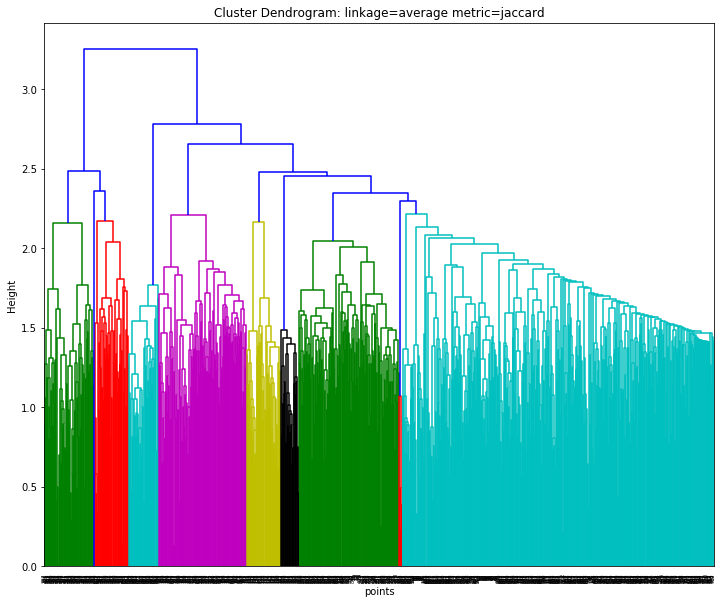

In [210]:
from scipy.cluster.hierarchy import linkage, dendrogram
import sys
import matplotlib.pyplot as plt
%matplotlib inline

n_samples = 1000
# linkage = 'complete'
# metric = 'jaccard'

distxy = get_distance_matrix(X[:1000])

plt.figure(figsize=(12,10))
# R = dendrogram(linkage(distxy, method='average'), p=5, truncate_mode='level', get_leaves=True)
R = dendrogram(linkage(distxy, method='average'))
plt.xlabel('points')
plt.ylabel('Height')
plt.title("Cluster Dendrogram: linkage=average metric=jaccard")

In [150]:
R.keys()

dict_keys(['dcoord', 'color_list', 'leaves', 'icoord', 'ivl'])

In [ ]:
R['color_list']

In [69]:
color_list = np.array(R['color_list'])
leaves = np.array(R['leaves'])
pdf.urlkeys[leaves[color_list=='m']]

/Users/tristan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 999
  """Entry point for launching an IPython kernel.


890    [wine, diningout, newintown, nightlife, socialnetwork, livemusic, fun-times, drinking, movie-nig...
902                                                     [acting, beginners-acting-training, actor, improv]
907    [spanish, digcam, photo, photography-classes, portrait-photography, espanol, photo-walks, native...
300    [settlers, cardgame, games, roleplaying-games-rpgs, tabletop-role-playing-and-board-games, Euro-...
195    [apache-spark, opensource, python, hadoop, big-data, machine-learning, data-analytics, predictiv...
201    [opensource, softwaredev, web-development, computer-programming, social-coding, coding-for-begin...
296    [network-management-and-monitoring, it-professionals, infrastructure-as-code, data-center-and-op...
260    [mozilla, opensource, softwaredev, newtech, web, web-development, programming-languages, functio...
286    [self-improvement, arabic-culture, diningout, fun-times, expat, egyptian-expats, arabic, egyptia...
237    [entrepreneurship, digital-hea

color_threshold : double, optional
    For brevity, let :math:`t` be the ``color_threshold``.
    Colors all the descendent links below a cluster node
    :math:`k` the same color if :math:`k` is the first node below
    the cut threshold :math:`t`. All links connecting nodes with
    distances greater than or equal to the threshold are colored
    blue. If :math:`t` is less than or equal to zero, all nodes
    are colored blue. If ``color_threshold`` is None or
    'default', corresponding with MATLAB(TM) behavior, the
    threshold is set to ``0.7*max(Z[:,2])``.

In [171]:
0.7*max(distxy[:,2])

0.69999999999999996

In [105]:
from sklearn.cluster import DBSCAN
# show_cluster_result(model)
pair_dist = DistanceMetric.get_metric('jaccard').pairwise(vectorized_urlkeys.todense())
# pair_dist =
# replace nan by 1
ind_zeros = np.where(np.isnan(pair_dist))
pair_dist[ind_zeros] = 1.
print(pair_dist)

dbscan = DBSCAN(eps=0.7, min_samples=4, metric='precomputed', n_jobs=-1)

pred = dbscan.fit_predict(pair_dist)
print(pred)

[[ 0.          1.          1.         ...,  1.          1.          1.        ]
 [ 1.          0.          0.13333333 ...,  1.          1.          1.        ]
 [ 1.          0.13333333  0.         ...,  1.          1.          1.        ]
 ..., 
 [ 1.          1.          1.         ...,  0.          0.70588235
   0.73913043]
 [ 1.          1.          1.         ...,  0.70588235  0.          0.64705882]
 [ 1.          1.          1.         ...,  0.73913043  0.64705882  0.        ]]


TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [79]:
show_cluster_result(dbscan)

#### cluster -1 with count: 375 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'adventure', 'entrepreneurship', 'singles', 'social', 'socialnetwork', 'newintown', 'self-improvement'])
#### cluster 6 with count: 123 ####
dict_keys(['fun-times', 'professional-networking', 'diningout', 'adventure', 'entrepreneurship', 'outdoors', 'social', 'socialnetwork', 'newintown', 'self-improvement'])
#### cluster 13 with count: 111 ####
dict_keys(['fun-times', 'softwaredev', 'diningout', 'nightlife', 'livemusic', 'outdoors', 'social', 'newintown', 'socialnetwork', 'adventure'])
#### cluster 1 with count: 82 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'adventure', 'social', 'socialnetwork', 'softwaredev', 'newintown', 'newtech', 'self-improvement'])
#### cluster 8 with count: 46 ####
dict_keys(['fitness', 'sports', 'diningout', 'socialnetwork', 'singles', 'outdoors', 'newintown', 'computer-programming', 'fun-times', 'excercise'])
#### cluster 15 with count: 45 ####
dict_keys(['social

In [80]:
print_cluster(dbscan, 3)

#### cluster 3 with count: 22 ####
45                                             [eating-drinking-talking-laughing-etc, locals-new-in-town]
46    [beppegrillo, politica, decrescita, energie-rinnovabili, music, carrara, common-good, movimento-...
47    [hiking, lgbtfriends, womens-hiking, Lesbian, lesbian-friends, straight-and-gay-welcome, san-fra...
48    [containers, kubernetes, google-cloud-platform, machine-learning, big-data, cloud-computing, ten...
50    [personal-development, self-improvement, social-anxiety, communication-skills, toastmasters, pro...
51                           [figuredrawing, fine-arts, sketching, draw, life-drawing, free-hand-drawing]
52    [alternative-medicine, guided-meditation, energy-healing, channeling, past-lives, akashic-record...
53                                  [computer-programming-c-c, c, c-c, software-engineering, softwaredev]
54    [group-photo-shoots, photo-walks, location-photography, amateur-photography, street-photography,...
55    [nutr

In [81]:
# compute distance matrix
from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import DistanceMetric

In [200]:
T = [[0,1,1,0,1],[0,0,1,1,0]]
DistanceMetric.get_metric('jaccard').pairwise(T)

array([[ 0.  ,  0.75],
       [ 0.75,  0.  ]])

In [114]:
def tristan_distance(u, v):
    u_and_v = sum(u & v)
    if u_and_v == 0:
        return 1
    else:
        return 1/u_and_v

In [115]:
X_bin = vectorizer.fit_transform(X[:500])
# X_bin.todense()
y = pdist(X_bin.todense(), metric=tristan_distance)
X_train = squareform(y)

In [116]:
X_train

array([[ 0.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.        ,  0.07692308, ...,  1.        ,
         1.        ,  1.        ],
       [ 1.        ,  0.07692308,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       ..., 
       [ 1.        ,  1.        ,  1.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.        ,  0.5       ],
       [ 1.        ,  1.        ,  1.        , ...,  1.        ,
         0.5       ,  0.        ]])

In [120]:
dbscan = DBSCAN(eps=0.2, min_samples=4, metric='precomputed', n_jobs=-1)

pred = dbscan.fit_predict(X_train)
print(pred)

[-1 -1 -1  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1  0  0 -1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1 -1  1 -1
 -1  1 -1  1  1  1 -1 -1  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1  2
  2  2  2 -1 -1 -1  1 -1  1 -1 -1  0 -1  0 -1  0  0  0 -1 -1  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0 -1  0  0  0 -1 -1  0  0  0  0  0  0  0 -1 -1  0  0  0  0  0  0  0
  0  0 -1  0 -1  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  0  0  0  0 -1  0  0  0  0  0
  0 -1  0 -1  0  0  0  0 -1 -1  0  0  0  0 -1  0  0  0 -1  0  0 -1 -1  0  0
  0  0  0  0  0 -1 -1  0 -1 -1  0  0  0  0  0  0  0 -1  0  0 -1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0 -1  0 -1
  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  3  3 -1  3

In [121]:
show_cluster_result(dbscan)

#### cluster 0 with count: 181 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'adventure', 'singles', 'social', 'newintown', 'computer-programming', 'softwaredev', 'socialnetwork'])
#### cluster -1 with count: 141 ####
dict_keys(['outdoors', 'diningout', 'adventure', 'socialnetwork', 'social', 'fun-times', 'language', 'singles', 'newintown', 'hiking'])
#### cluster 5 with count: 110 ####
dict_keys(['fun-times', 'outdoors', 'diningout', 'nightlife', 'adventure', 'entrepreneurship', 'hiking', 'social', 'newintown', 'socialnetwork'])
#### cluster 1 with count: 33 ####
dict_keys(['outdoors', 'fitness', 'web-development', 'any-activities-both-indoor-and-outdoor', 'entrepreneurship', 'singles', 'softwaredev', 'excercise', 'newintown', 'hiking'])
#### cluster 4 with count: 26 ####
dict_keys(['hiking', 'diningout', 'adventure', 'entrepreneurship', 'outdoors', 'social', 'newintown', 'excercise', 'fitness', 'self-improvement'])
#### cluster 3 with count: 5 ####
dict_keys(['free-in-new-yor

/Users/tristan/anaconda3/lib/python3.5/site-packages/pandas/core/internals.py:252: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 500
  return self.values[slicer]
/Users/tristan/anaconda3/lib/python3.5/site-packages/pandas/indexes/base.py:1434: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 500
  result = getitem(key)


/Users/tristan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


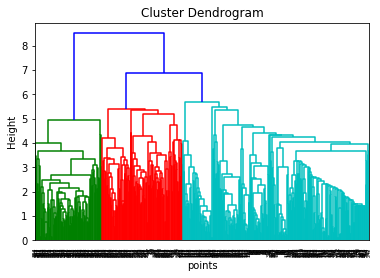

In [123]:
R = dendrogram(linkage(X_train, method='average'))
plt.xlabel('points')
plt.ylabel('Height')
plt.title('Cluster Dendrogram')

In [127]:
color_list = np.array(R['color_list'])
leaves = np.array(R['leaves'])
pdf.urlkeys[leaves[color_list=='c']]

/Users/tristan/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 500 but corresponding boolean dimension is 499
  This is separate from the ipykernel package so we can avoid doing imports until


192    [womens-support, womens-networking, professional-women, fashion-and-style, women-entrepreneurs, ...
196    [womens-support, womens-networking, professional-women, fashion-and-style, women-entrepreneurs, ...
149    [opensource, newtech, cloud-computing, hadoop, big-data, mapreduce, data-visualization, predicti...
128    [fitness, singles, diningout, movies, newintown, travel, nightlife, socialnetwork, women, fun-ti...
135    [fitness, singles-30s-and-40s, 30s, women-over-40, 30s-and-40s, hiking, newintown, socialnetwork...
127    [brit, american, diningout, expatgerman, indian, newintown, expatnewzealander, expatfrench, exch...
133    [astrology, metaphysics, psychics, spiritualism, self-improvement, lawofattraction, new-age, spi...
141    [musicians, live-jazz-music, attend-live-blues-performances, live-blues, singles, newintown, nig...
121                                                                                                 [acim]
152    [lisp, programming-languages, 

In [134]:
n_urlkeys = np.sum(vectorizer.fit_transform(pdf.urlkeys).todense(), axis=1)

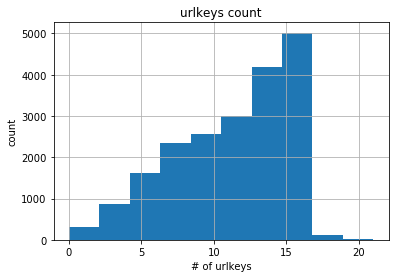

In [157]:

df = pd.DataFrame(list(map(lambda item: len(item), X)))
df.hist()
plt.title("urlkeys count")
plt.xlabel("# of urlkeys")
plt.ylabel("count")